# SPICAV Exploratory Data Analysis

## This notebook explores the SPICAV dataset from Venus Express satellite

## Author: g.mahapatra@tudelft.nl

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import read_spicav_ir as rd     # This is a utility library to read SPICAV data written by Loic Rossi, LATMOS.
import pymiedap.pymiedap as pmd # This is a Python library to perform RT related computations.
import pandas as pd

In [78]:
# set the path to SPICAV data
path = '/Users/gouravmahapatr/Dropbox/PhD/spicav_data'

### Make a function to build the dataframe

In [79]:
# read the data
def make_orbitdatadf(orbitnum,orbittype):
    data = rd.processing_orbits(orbitnum,orbittype)   # data is an object
    # calculate the azimuth
    data.geo.calc_azimuth()
    # calculate the beta (rotation angle)
    cosbeta = pmd.get_cosbeta(np.array(data.geo.phase),np.array(data.geo.sza),np.array(data.geo.emission),np.array(data.geo.azimuth)) # in radians
    beta = np.degrees(np.arccos(cosbeta)) # Converted into degrees
    # get the localtime
    localtime = data.geo.local_time     
    # make a dataframe
    orbitdatadf = pd.DataFrame(localtime,columns=['localtime'])
    orbitdatadf['lat'] = data.geo.Lat
    orbitdatadf['lon'] = data.geo.Lon
    orbitdatadf['phase'] = data.geo.phase
    orbitdatadf['sza'] = data.geo.sza
    orbitdatadf['emission'] = data.geo.emission
    orbitdatadf['azimuth'] = data.geo.azimuth
    orbitdatadf['beta'] = beta
    orbitdatadf['orbitnum'] = orbitnum
    orbitdatadf['orbittype'] = orbittype
    return orbitdatadf

# call
orbitdatadf = make_orbitdatadf(100,2)
orbitdatadf = pd.concat([orbitdatadf,make_orbitdatadf(400,10)],ignore_index=True)
orbitdatadf

/Users/gouravmahapatr/Dropbox/PhD/spicav_data/calibrated_data2013/SPIV_0BR_0100A02_N_05_calibr_2013_polar_virtis.DAT
nbl = 2
fnb = 859


/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:318: RuntimeWarning: invalid value encountered in less
  r0_invalid = (radf_d0<0)  # identification of negative radiance values
/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:319: RuntimeWarning: invalid value encountered in less
  r1_invalid = (radf_d1<0)
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 file(s) have been read
/Users/gouravmahapatr/Dropbox/PhD/spicav_data/calibrated_data2013/SPIV_0BR_0400A10_N_05_calibr_2013_polar_virtis.DAT
nbl = 4
fnb = 430


/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:175: RuntimeWarning: invalid value encountered in arccos
  delta_phi = np.degrees(np.arccos(c_delta_phi))


1 file(s) have been read


,localtime,lat,lon,phase,sza,emission,azimuth,beta,orbitnum,orbittype
0,21.277778,41.1324,264.6631,125.14,125.16,0.02,NaN,180.000000,100,2
1,21.277778,41.2371,264.6633,125.07,125.09,0.02,0.000051,180.000000,100,2
2,21.277778,41.3421,264.6636,125.01,125.03,0.02,0.000025,180.000000,100,2
3,21.277778,41.4472,264.6638,124.95,124.97,0.02,0.000023,180.000000,100,2
4,21.277778,41.5524,264.6641,124.88,124.90,0.02,NaN,180.000000,100,2
...,...,...,...,...,...,...,...,...,...,...
1284,15.652222,-33.0621,196.2390,91.56,59.93,31.63,NaN,0.000000,400,10
1285,15.649444,-33.0830,196.2800,91.56,59.90,31.66,NaN,0.000000,400,10
1286,15.646667,-33.1039,196.3210,91.56,59.88,31.68,NaN,0.000000,400,10
1287,15.643889,-33.1247,196.3619,91.56,59.85,31.71,NaN,0.000000,400,10


### Get the orbits list that are within the orbit range 

In [80]:
# get the orbits list that are within a certain orbit range
orbit_list = rd.find_orbits(400,1500)        # this is a function from read_spicav_ir
orbit_listdf = pd.DataFrame(orbit_list,columns=['Orbit Number','Type'])
orbit_listdf

,Orbit Number,Type
0,400,10
1,400,11
2,401,9
3,401,10
4,402,7
...,...,...
524,1483,7
525,1485,7
526,1488,7
527,1489,7


###  Make a dataframe combining all the orbits found in orbit_list

In [87]:
reload = False
if reload:
    # call the make_orbitdatadf function on first item from the list
    orbitdatadf = make_orbitdatadf(orbit_list[0,0],orbit_list[0,1])

    # iterate through the rest of the orbit list while concatenating the data
    for i in range(len(orbit_list)):
        orbit_n = orbit_list[i,0]
        orbit_a = orbit_list[i,1]
        orbitdatadf = pd.concat([orbitdatadf,make_orbitdatadf(orbit_n,orbit_a)],ignore_index=True)
    orbitdatadf.to_csv('orbitdata.csv',index=False)
else:
    orbitdatadf = pd.read_csv('../outputs/orbitdata.csv')  # or just load the saved dataframe

# calculate the beta (rotation angle)
cosbeta = pmd.get_cosbeta(np.array(orbitdatadf['phase']),np.array(orbitdatadf['sza']),np.array(orbitdatadf['emission']),np.array(orbitdatadf['azimuth'])) # in radians
beta = np.degrees(np.arccos(cosbeta)) # Converted into degrees
orbitdatadf['beta'] = beta

orbitdatadf.head(10)

/Users/gouravmahapatr/lib/python/PyMieDAP-0.1-py3.7-macosx-10.7-x86_64.egg/pymiedap/pymiedap.py:854: RuntimeWarning: divide by zero encountered in true_divide
  cb = num/denom
/Users/gouravmahapatr/lib/python/PyMieDAP-0.1-py3.7-macosx-10.7-x86_64.egg/pymiedap/pymiedap.py:854: RuntimeWarning: invalid value encountered in true_divide
  cb = num/denom


,localtime,lat,lon,phase,sza,emission,azimuth,orbitnum,orbittype,beta
0,16.731389,-13.9887,179.9898,90.82,71.09,19.73,179.999999,400,10,8.537736e-07
1,16.729167,-14.0694,180.0232,90.82,71.06,19.76,179.999998,400,10,1.707547e-06
2,16.726944,-14.1499,180.0567,90.82,71.03,19.79,NaN,400,10,0.000000e+00
3,16.724722,-14.2302,180.0902,90.82,71.00,19.82,NaN,400,10,8.537736e-07
4,16.722500,-14.3101,180.1237,90.82,70.98,19.85,178.110673,400,10,1.786327e+00
5,16.720278,-14.3898,180.1573,90.82,70.95,19.88,178.111872,400,10,1.784872e+00
6,16.718056,-14.4693,180.1909,90.82,70.92,19.90,179.999999,400,10,8.537736e-07
7,16.715833,-14.5485,180.2245,90.82,70.89,19.93,179.999999,400,10,1.478779e-06
8,16.713611,-14.6275,180.2582,90.82,70.86,19.96,179.999998,400,10,0.000000e+00
9,16.711389,-14.7062,180.2919,90.82,70.84,19.99,178.116236,400,10,1.779562e+00


### Implement a filter 

In [88]:
def filter_data(orbitdatadf,fields=list([[None,None,None]])):
    '''
    This function implements a filter on the dataframe. 
    The fields list stores lists containing [fieldname,minval,maxval]
    '''
    for fieldlist in fields:
        if fieldlist[0] == None:
            pass
        else:
            orbitdatadf = orbitdatadf[(orbitdatadf[fieldlist[0]]>=fieldlist[1])&(orbitdatadf[fieldlist[0]]<=fieldlist[2])]
    return orbitdatadf

fields=list([['localtime',6,18],['lat',-60,60]])
#print(fields[1])
orbitdatadf_filtered = filter_data(orbitdatadf,fields=fields)
orbitdatadf_filtered

,localtime,lat,lon,phase,sza,emission,azimuth,orbitnum,orbittype,beta
0,16.731389,-13.9887,179.9898,90.82,71.09,19.73,179.999999,400,10,8.537736e-07
1,16.729167,-14.0694,180.0232,90.82,71.06,19.76,179.999998,400,10,1.707547e-06
2,16.726944,-14.1499,180.0567,90.82,71.03,19.79,NaN,400,10,0.000000e+00
3,16.724722,-14.2302,180.0902,90.82,71.00,19.82,NaN,400,10,8.537736e-07
4,16.722500,-14.3101,180.1237,90.82,70.98,19.85,178.110673,400,10,1.786327e+00
...,...,...,...,...,...,...,...,...,...,...
263290,14.307500,15.3176,339.6980,29.18,38.66,11.00,26.609677,1491,8,1.449773e+02
263291,14.308056,15.2363,339.6896,29.14,38.64,11.01,26.498935,1491,8,1.450996e+02
263292,14.308611,15.1551,339.6812,29.11,38.61,11.02,26.569558,1491,8,1.449893e+02
263293,14.309444,15.0740,339.6728,29.07,38.58,11.03,26.548804,1491,8,1.449944e+02


### Make scatter plots for different geometries

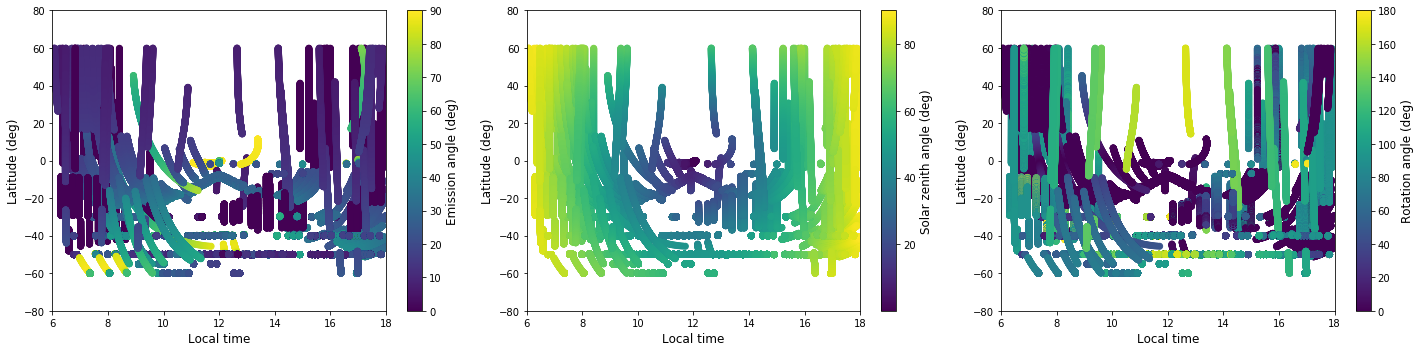

In [97]:
# make plots
#os.chdir('../figures/')
%matplotlib inline
plt.figure(figsize=[20,5])
plt.subplot(131)
plt.scatter(orbitdatadf_filtered['localtime'],orbitdatadf_filtered['lat'],c=orbitdatadf_filtered['emission'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Emission angle (deg)',fontsize='large')
plt.xlabel('Local time',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
#plt.tight_layout()
#plt.savefig('emission_plot_400to1500.pdf')
#plt.close()

plt.subplot(132)
plt.scatter(orbitdatadf_filtered['localtime'],orbitdatadf_filtered['lat'],c=orbitdatadf_filtered['sza'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Solar zenith angle (deg)',fontsize='large')
plt.xlabel('Local time',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
#plt.tight_layout()
#plt.savefig('sza_plot_400to1500.pdf')
#plt.close()

plt.subplot(133)
plt.scatter(orbitdatadf_filtered['localtime'],orbitdatadf_filtered['lat'],c=orbitdatadf_filtered['beta'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Rotation angle (deg)',fontsize='large')
plt.xlabel('Local time',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
plt.tight_layout()
plt.savefig('../outputs/geometry.png')

In [96]:
plt.savefig('../outputs/geometry.png')

<Figure size 432x288 with 0 Axes>